# Analyze images with CLIP

In [1]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import subprocess
import shutil
import os
import csv as csvlib


In [2]:
RESOURCES = "./resources/pma_clean"
RESOURCES_SIMPLE = "./resources/image_text"
RESOURCES_CLUSTER = "./resources/output/cluster_1"

## Compare Image to Text

Load the models in memory

In [3]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Different tests, it seems like entitys are also recognized like Jean Marie Lepen or Jacques Chirac

In [55]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Jacques_Chirac_%281997%29_%28cropped%29.jpg/1200px-Jacques_Chirac_%281997%29_%28cropped%29.jpg"
img = Image.open(requests.get(url, stream=True).raw)
# img = Image.open(os.path.join(RESOURCES, '0d9a40d9ccaab988d1feba59ae5cbe3a01b02249.jpg')).convert('RGB')

inputs = processor(text=["homme", "femme", "jacques chirac", "jean-marie lepen"], images=img, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
print(logits_per_image)
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
probs

tensor([[22.3736, 20.5337, 32.0766, 31.1968]], grad_fn=<PermuteBackward0>)


tensor([[4.3185e-05, 6.8586e-06, 7.0674e-01, 2.9321e-01]],
       grad_fn=<SoftmaxBackward0>)

test with several images

In [156]:
# test with test labels
labels = ["homme", "femme", "ventre", "bébé", "code-barre", "manifestation", "dessin", "lgbt", "eceinte", "marianne", "texte"]
labels = ["manifestation", "caddie", "femme enceinte", "code-barre", "barcode", "article journal", "bébé", "Manif pour Tous", "Eugénisme", "marianne", "ministre", "famille"]
labels = ["demonstration", "shopping-kart", "pregnant woman", "pregnant man", "barcode", "newspaper", "child", "eugenism", "bioethics", "minister", "flyer", "drawing", "belly", "indian"]
labels = ["manifestation de femmes avec une banderolle", "bébé dans un caddie avec de l'argent", "bébé avec un code barre sur le front", "bébé gonflable avec un code barre", "agnès buzyn", 
          "des femmes indiennes enceintes avec du texte", "des femmes indiennes enceintes", 
          "thomas beatie", "main de bébé avec un code barre", "tract sur famille homophobe",
          "article de journal avec un ventre et un code barre", "un ventre enceint avec un code barre", "une femme indienne enceinte", "un ventre avec des mains dessus"
         ]
# test the complete list of labels
with open(os.path.join('labels_kenza.csv'), 'r', encoding='utf-8') as f:
    reader = csvlib.reader(f, delimiter=',', quotechar='"')
    labels = [row[0] for row in reader]
del labels[0]
# labels
labels = ["demonstration", "shopping-kart", "pregnant woman", "thomas beatie", "barcode", "newspaper", "child", "eugenism", "bioethics", "minister", "flyer", "drawing", "belly", "indian", "agnès buzyn", "marlène schiappa", "manif pour tous"]


In [ ]:
labels = ["barcode", "child", "belly"]
for file in os.listdir(RESOURCES_CLUSTER):
    path = os.path.join(RESOURCES_CLUSTER, file)
    img = Image.open(path).convert('RGB')
    inputs = processor(text=labels, images=img, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    # print(logits_per_image.item(), "barcode" if logits_per_image.item() > 21 else "else")
    probs = logits_per_image.softmax(dim=1).detach().numpy()
    labels_with_probs = [(k,v) for k,v in zip(labels, probs[0])]
    sorted_labels_with_probs = sorted(labels_with_probs, key=lambda tup: tup[1], reverse=True)
    print(sorted_labels_with_probs[0: 2])
    display(img)

In [ ]:
for file in os.listdir(RESOURCES_SIMPLE):
    # print(file)
    path = os.path.join(RESOURCES_SIMPLE, file)
    img = Image.open(path).convert('RGB')
    inputs = processor(text=labels, images=img, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).detach().numpy()
    labels_with_probs = [(k,v) for k,v in zip(labels, probs[0])]
    sorted_labels_with_probs = sorted(labels_with_probs, key=lambda tup: tup[1], reverse=True)
    print(sorted_labels_with_probs[0:2])
    display(img)

## Clusterize Images

we'll use a different model for this one

In [ ]:
model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")

function that will be used to transform one image into vectors

In [161]:
def vectorize(img):
    input1 = processor(images=img, return_tensors="pt")
    output1 = model(**input1)
    pooled_output1 = output1[1].detach().numpy()  # pooled_output
    return pooled_output1.flatten()

### Transform images in vectors (no text)

In [177]:
vectors = []
labels = []
for file in os.listdir(RESOURCES):
    img = Image.open(os.path.join(RESOURCES, file)).convert('RGB')
    vectors.append(vectorize(img))
    labels.append(file)
labels = np.asarray(labels)

### Transform vectors in 2D

In [180]:
from sklearn.decomposition import PCA

pca = PCA(2)
transformed = pca.fit_transform(vectors)

### Compute clusters

In [79]:
clusters = KMeans(n_clusters=3).fit_predict(transformed)

### Automatically find right number of clusters

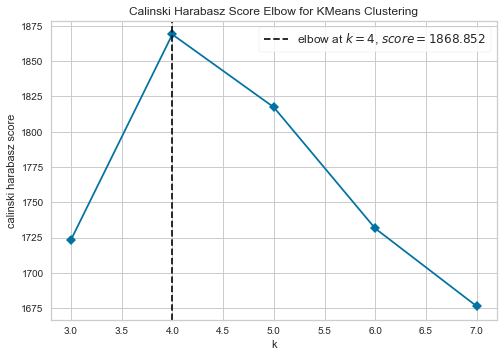

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [182]:
from yellowbrick.cluster import KElbowVisualizer

kmean = KMeans()
visualizer = KElbowVisualizer(kmean, k=(3,8), metric='calinski_harabasz', timings=False)

visualizer.fit(transformed)
visualizer.show()

### Plot the clusters and copy files in a dedicated folder


In [67]:
import matplotlib.pyplot as plt
from pathlib import Path

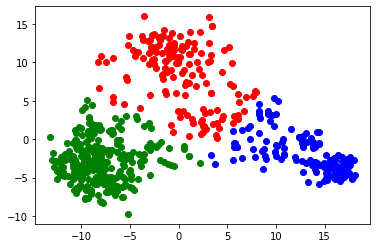

In [81]:
colors = ['red', 'blue', 'green', 'orange', 'black', 'pink', 'brown', 'purple']
for i, cluster in enumerate(list(set(clusters))):
    filtered_label = transformed[clusters == cluster]
    plt.scatter(filtered_label[:,0] , filtered_label[:,1] , color = colors[i])
    cluster_labels = labels[clusters == cluster]
    for file in cluster_labels:
        folder = os.path.join('./resources/output/', f'cluster_{cluster}')
        output_folder = Path(folder).mkdir(parents=True, exist_ok=True)
        shutil.copy(os.path.join(RESOURCES, file), os.path.join(folder, file))
plt.show()

## Find Similar Images

Start with one image and find all the similar images: (maybe use our own similarity mesure combining k-mean cluster + tags + cos_sin

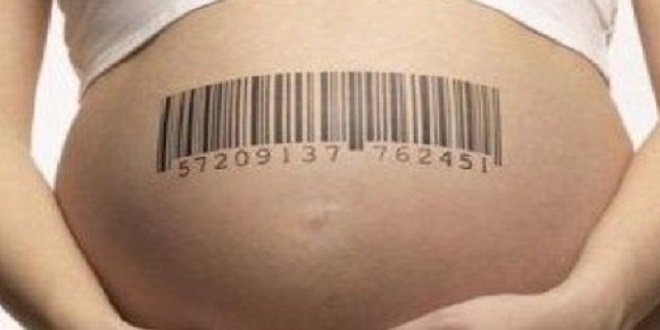

In [172]:
img = Image.open(os.path.join(RESOURCES, '50de4d9533ed05e3008f726f85e15498fe2ca6fb.jpg')).convert('RGB')

vector = vectorize(img)
display(img)

In [176]:
for file in os.listdir(RESOURCES_SIMPLE):
    img = Image.open(os.path.join(RESOURCES_SIMPLE, file)).convert('RGB')
    vector_temp = vectorize(img)
    # display(img)
    print(cosine_similarity([vector, vector_temp]))

[[1.         0.11978039]
 [0.11978039 1.0000001 ]]
[[1.        0.3291068]
 [0.3291068 1.0000001]]
[[1.        0.6137187]
 [0.6137187 1.       ]]
[[1.         0.15811422]
 [0.15811422 1.        ]]
[[1.         0.25318024]
 [0.25318024 0.99999976]]
[[1.         0.21065547]
 [0.21065547 1.        ]]
[[1.         0.39260882]
 [0.39260882 0.99999994]]
[[1.         0.46424022]
 [0.46424022 1.        ]]
[[1.        0.6465865]
 [0.6465865 0.9999998]]
[[1.         0.15002373]
 [0.15002373 0.99999994]]
[[1.         0.18034284]
 [0.18034284 1.0000001 ]]
[[1.         0.45764604]
 [0.45764604 1.        ]]
[[1.         0.82334894]
 [0.82334894 0.99999994]]
[[1.         0.49937874]
 [0.49937874 1.0000001 ]]
[[1.         0.53097683]
 [0.53097683 1.        ]]
